In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
from bisect import bisect_left
import torch.nn as nn
import torch
import time
from collections import defaultdict

from lobio.lob.limit_order import Order, AMOUNT_TICK, PRICE_TICK, EventType, OrderType, TraderId, Side
from lobio.lob.order_book import  OrderBook, OrderBookSimple, OrderBookSimple2, OrderBookTrunc, OrderBookSimple3
from lobio.accounting.pnl_counter import PnL_Counter, PnL_Counter2
from lobio.utils.utils import group_diffs, group_historical_trades, group_orders, get_initial_order_book
from queue_dynamic.models.models import GaussianPDFModel, ModelPerceptron
from queue_dynamic.simulation import run_true_simulation, run_pred_simulation
from queue_dynamic.losses import reinforce_objective, reinforce_objective_with_baseline

sns.set_theme(style="darkgrid")

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
diffs_prepared_file = "../data/diffs_prepared.npy"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
orders_prepared_file = "../data/orders_prepared.npy"
pl_to_enter_file = "../data/price_level_to_enter.npy"

with open(init_lob_prepared_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_prepared_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_prepared_file, 'rb') as file:
    orders = np.load(file)

with open(pl_to_enter_file, 'rb') as file:
    pl_to_enter = np.load(file)

In [3]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))
n_poses = len(pl_to_enter)

100%|██████████| 23209/23209 [00:01<00:00, 14209.79it/s]


In [4]:
len(orders_per_diff), len(diffs_grouped), n_poses

(23209, 23209, 4120)

In [5]:
order_book = get_initial_order_book(init_lob, OrderBookTrunc)

mid_prices = []
for i, diff in enumerate(tqdm(diffs_grouped)):
    mid_prices.append((order_book.bids[0][0] + order_book.asks[0][0]) / 2)
    cur_orders = orders_per_diff[i]
    for j, (_, order) in enumerate(cur_orders):
        if order.type == OrderType.MARKET:
            order_book.set_market_order([order.quote, order.side])
        else:
            order_book.set_limit_order([order.base, order.quote, order.side])
    
    order_book.apply_historical_update(diff)

mid_prices = np.array(mid_prices)

100%|██████████| 23209/23209 [00:02<00:00, 9435.33it/s] 


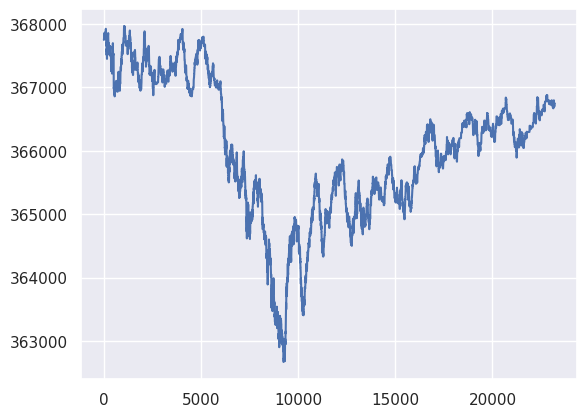

In [6]:
plt.plot(mid_prices)
plt.show()

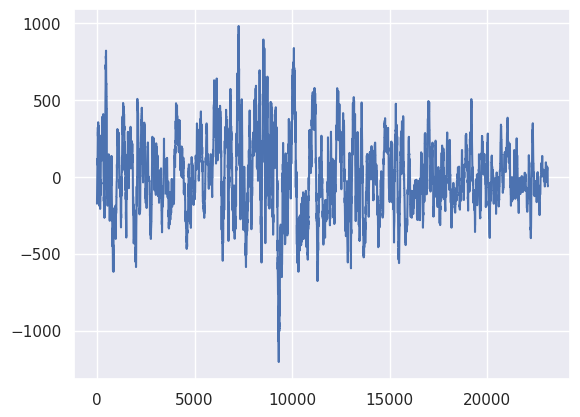

In [7]:
MAX_HORIZONT = 100
price_lags = mid_prices[:-MAX_HORIZONT] - mid_prices[MAX_HORIZONT:]
plt.plot(price_lags)
plt.show()

In [21]:
trade_action = []

for i, price_dif in enumerate(price_lags):
    if price_dif > 30:
        trade_action.append(1)
    elif price_dif < -30:
        trade_action.append(-1)
    else:
        trade_action.append(0)

for _ in range(MAX_HORIZONT):
    trade_action.append(0)

trade_action = np.array(trade_action)

In [46]:
order_book = get_initial_order_book(init_lob, OrderBookSimple3)
accounter = PnL_Counter()
accounter2 = PnL_Counter2()
my_quote = 0
my_base = 0
order_running_id = 0
for i, diff in enumerate(tqdm(diffs_grouped)):
    if i % 30 == 0:
        if trade_action[i] == 1:
            order_book.bids[0].place_my_order(0, order_running_id)
            order_running_id += 1
        elif trade_action[i] == -1:
            order_book.asks[0].place_my_order(0, order_running_id)
            order_running_id += 1
    
    if i % 50 == 0:
        if my_quote < 0:
            my_quote = 0


    cur_orders = orders_per_diff[i]
    for j, (_, order) in enumerate(cur_orders):
        if order.type == OrderType.MARKET:
            my_orders_eaten, my_amount, my_money = order_book.set_market_order([order.quote, order.side])
            if order.side == Side.BUY:
                my_quote -= my_amount
                my_base += my_money
            else:
                my_quote += my_amount
                my_base -= my_money
        else:
            order_book.set_limit_order([order.base, order.quote, order.side])
    
    order_book.apply_historical_update(diff)
    accounter.collect_statistic(my_quote, (order_book.bids[0].base + order_book.asks[0].base) / 2)
    accounter2.collect_statistic(my_quote, (order_book.bids[0].base + order_book.asks[0].base) / 2, my_base)

100%|██████████| 23209/23209 [00:01<00:00, 17555.81it/s]


In [48]:
#pes_pnl = accounter.calculate_pnl()
#pes_pnl /= 10**(PRICE_TICK + AMOUNT_TICK)
#pes_pnl2 = accounter2.calculate_pnl()
opt_pnl = accounter.calculate_pnl()
opt_pnl /= 10**(PRICE_TICK + AMOUNT_TICK)
opt_pnl2 = accounter2.calculate_pnl()

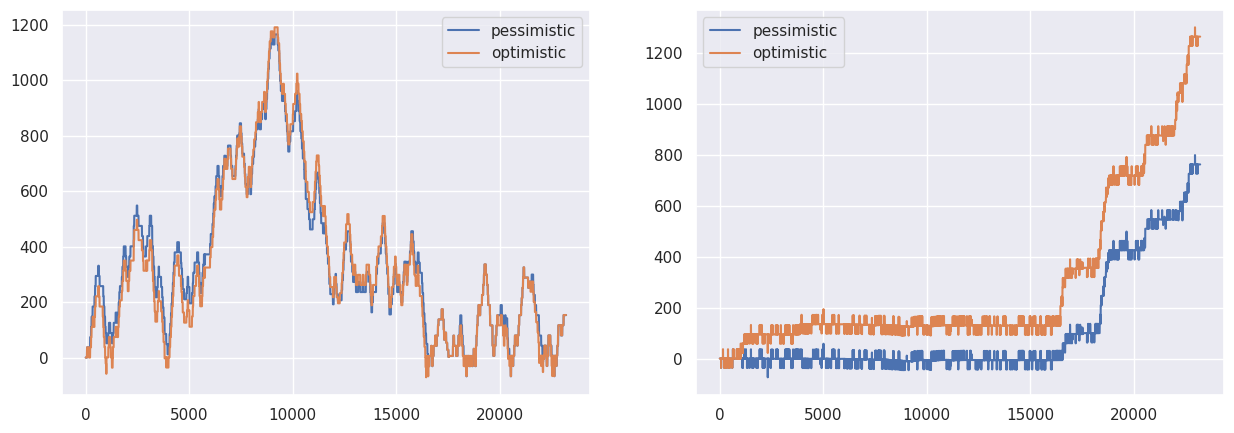

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(pes_pnl, label='pessimistic')
axes[0].plot(opt_pnl, label='optimistic')
axes[0].legend()

axes[1].plot(pes_pnl2, label='pessimistic')
axes[1].plot(opt_pnl2, label='optimistic')
axes[1].legend()
plt.show()

# REINFORCE

In [13]:
dim_observation = 3
dim_action = 1
dim_hidden = 8
n_hidden_layers = 1
std = 0.01
scale_factor = 5
gamma = 0.95
lr = 0.001
N_iter = 40
N_episode = 300
n_exp = 10

In [14]:
seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

agent_network = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
rl_model = GaussianPDFModel(
    model=agent_network,
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=scale_factor,
    std=std,
)
optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

In [15]:
running_loss = []
running_reward = []
baseline = torch.FloatTensor([])
for i in tqdm(range(N_iter)):
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))

    optimizer.zero_grad()
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
    #loss, reward, baseline = reinforce_objective_with_baseline(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma, baseline)
    running_loss.append(loss.item())
    running_reward.append(reward)

    loss.backward()
    optimizer.step()
    #scheduler.step()

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [02:34<00:00,  3.87s/it]


In [16]:
with torch.no_grad():
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)

print(reward)

0.9060773480662984


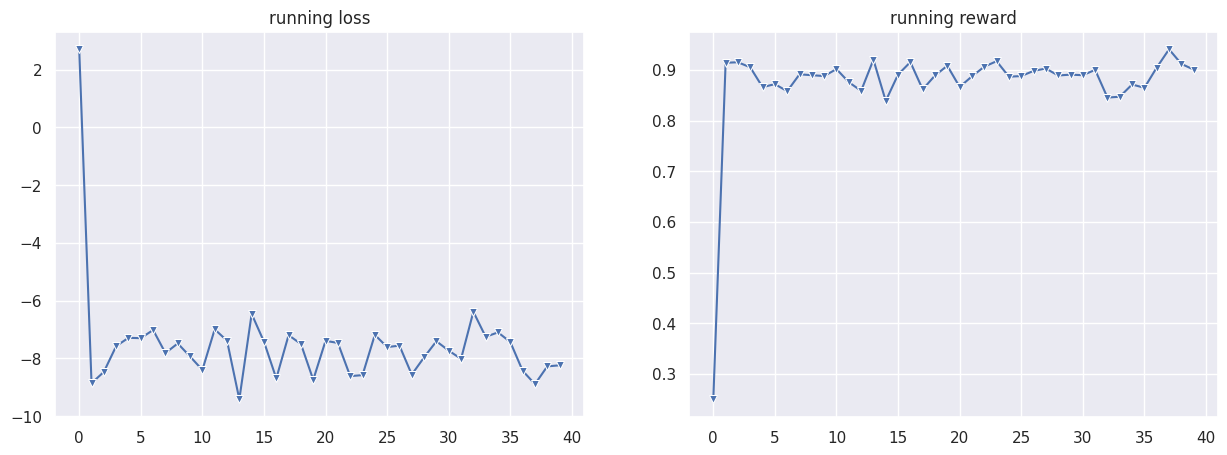

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()

In [20]:
params = {'dim_obs': dim_observation, 
          'dim_act': dim_action, 
          'dim_hid': dim_hidden,
          'n_hid_layers': n_hidden_layers,
          'std': std, 
          'scale_factor': scale_factor,
          'gamma': gamma,
          'lr': lr,
          'N_iter': N_iter,
          'N_episod': N_episode,
          'n_exp': n_exp,
          'dyn': 'U[0, 0.1]'
          }

with open('../good_runs/reinforce_uni/hypers.pkl', 'wb') as f:
    pickle.dump(params, f)

torch.save(rl_model, '../good_runs/reinforce_uni/model.pt')

In [50]:
order_book: OrderBookSimple3 = get_initial_order_book(init_lob, OrderBookSimple3)
accounter = PnL_Counter()
accounter2 = PnL_Counter2()
my_quote = 0
my_base = 0
order_running_id = 0

my_current_poses = {}


for i, diff in enumerate(tqdm(diffs_grouped)):
    mid_price = (order_book.bids[0].base + order_book.asks[0].base) * 10**(-PRICE_TICK) / 2
    if i % 30 == 0:
        if trade_action[i] == 1:
            if order_book.bids[0].my_order_id == None:
                my_current_poses[order_running_id] = [order_book.bids[0], 0, 0, order_book.bids[0].total_amount()]
            order_book.bids[0].place_my_order(0, order_running_id)
            order_running_id += 1
        elif trade_action[i] == -1:
            if order_book.asks[0].my_order_id == None:
                my_current_poses[order_running_id] = [order_book.asks[0], 0, 0, order_book.asks[0].total_amount()]
            order_book.asks[0].place_my_order(0, order_running_id)
            order_running_id += 1

    if i % 50 == 0:
        if my_quote < 0:
            my_quote = 0

    cur_orders = orders_per_diff[i]
    for j, (_, order) in enumerate(cur_orders):
        if order.type == OrderType.MARKET:
            my_orders_eaten, my_amount, my_money = order_book.set_market_order([order.quote, order.side])
            if order.side == Side.BUY:
                my_quote -= my_amount
                my_base += my_money
            else:
                my_quote += my_amount
                my_base -= my_money
            for my_eaten in my_orders_eaten:
                my_current_poses.pop(my_eaten)
        else:
            order_book.set_limit_order([order.base, order.quote, order.side])
    
    observations = []
    for info in my_current_poses.values():
        observations.append((info[1], info[2], mid_price))

    if len(observations):
        observations_tensor = torch.FloatTensor(observations)
        ratios = rl_model.sample(observations_tensor)
        for j, (order_id, info) in enumerate(my_current_poses.items()):
            info[0].queue_dynamic(ratios[j])
    
    my_orders_removed = order_book.apply_historical_update(diff)
    for my_removed in my_orders_removed:
        my_current_poses.pop(my_removed)

    for info in my_current_poses.values():
        info[1] += 1
        info[2] = info[0].total_amount() - info[3]
        info[3] = info[0].total_amount()
    accounter.collect_statistic(my_quote, (order_book.bids[0].base + order_book.asks[0].base) / 2)
    accounter2.collect_statistic(my_quote, (order_book.bids[0].base + order_book.asks[0].base) / 2, my_base)

100%|██████████| 23209/23209 [00:05<00:00, 4002.17it/s]


In [51]:
dyn_pnl = accounter.calculate_pnl()
dyn_pnl /= 10**(PRICE_TICK + AMOUNT_TICK)
dyn_pnl2 = accounter2.calculate_pnl()

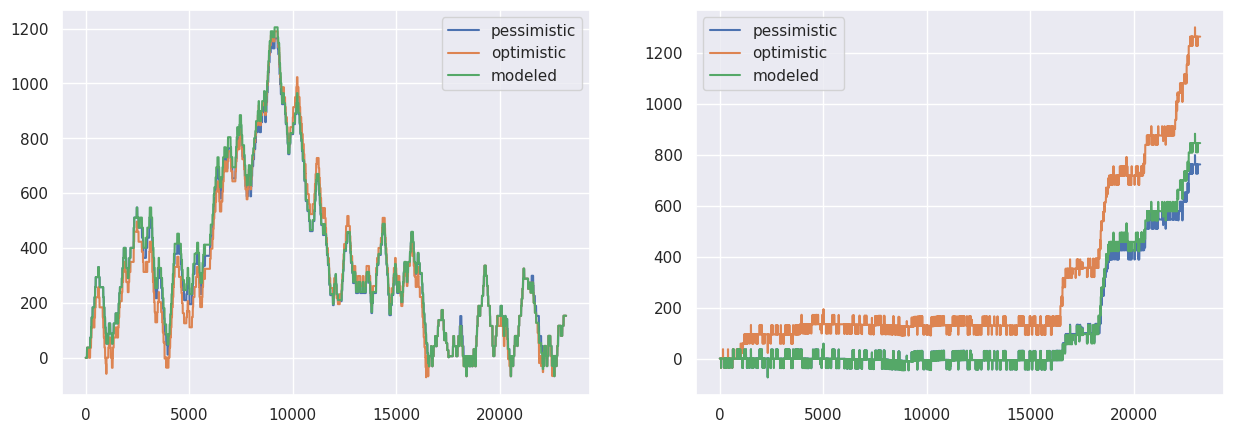

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(pes_pnl, label='pessimistic')
axes[0].plot(opt_pnl, label='optimistic')
axes[0].plot(dyn_pnl, label='modeled')
axes[0].legend()

axes[1].plot(pes_pnl2, label='pessimistic')
axes[1].plot(opt_pnl2, label='optimistic')
axes[1].plot(dyn_pnl2, label='modeled')
axes[1].legend()
plt.show()

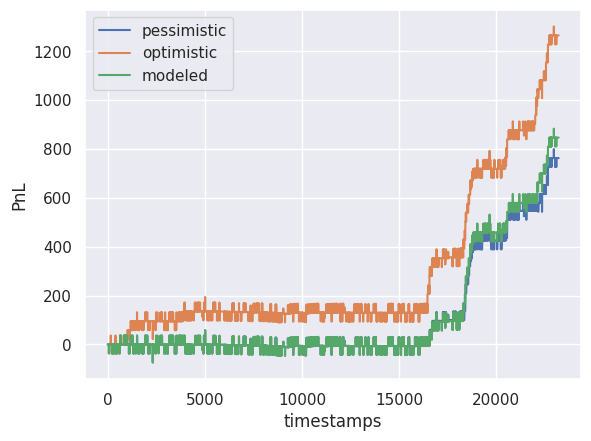

In [57]:
plt.plot(pes_pnl2, label='pessimistic')
plt.plot(opt_pnl2, label='optimistic')
plt.plot(dyn_pnl2, label='modeled')
plt.legend()
plt.xlabel('timestamps')
plt.ylabel('PnL')
#plt.savefig('../title_plots/PnL.svg', format='svg')
plt.show()

In [26]:
params = {'dim_obs': dim_observation, 
          'dim_act': dim_action, 
          'dim_hid': dim_hidden,
          'n_hid_layers': n_hidden_layers,
          'std': std, 
          'scale_factor': scale_factor,
          'gamma': gamma,
          'lr': lr,
          'N_iter': N_iter,
          'N_episod': N_episode,
          'n_exp': n_exp
          }
seeds = []
running_losses = []
running_rewards = []

for _ in range(n_exp):
    seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
    torch.manual_seed(seed)
    rng = np.random.default_rng(seed)
    seeds.append(seed)

    model_perc = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
    rl_model = GaussianPDFModel(
        model=model_perc,
        dim_observation=dim_observation,
        dim_action=dim_action,
        action_bounds=np.array([[0, 1]]),
        scale_factor=scale_factor,
        std=std,
    )
    optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

    running_loss = []
    running_reward = []
    for i in tqdm(range(N_iter)):
        #samples = rng.choice(pl_to_enter, size=1000, replace=False, axis=0)
        samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
        samples_ind.sort()
        samples = pl_to_enter[samples_ind]
        place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))

        optimizer.zero_grad()
        poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
        poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
        loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
        running_loss.append(loss.item())
        running_reward.append(reward)

        loss.backward()
        optimizer.step()

    running_losses.append(running_loss)
    running_rewards.append(running_reward)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


In [28]:
save_dir = f'../experiments/exp{101}/'
with open(save_dir + 'hypers.pkl', 'wb') as f:
    pickle.dump(params, f)
with open(save_dir + 'seeds.npy', 'wb') as f:
    np.save(f, seeds)
with open(save_dir + 'losses.npy', 'wb') as f:
    np.save(f, running_losses)
with open(save_dir + 'rewards.npy', 'wb') as f:
    np.save(f, running_rewards)

In [404]:
save_dir = f'../experiments/exp{15}/'
with open(save_dir + 'hypers.pkl', 'rb') as f:
    params = pickle.load(f)
with open(save_dir + 'seeds.npy', 'rb') as f:
    seeds = np.load(f)
with open(save_dir + 'losses.npy', 'rb') as f:
    losses = np.load(f)
with open(save_dir + 'rewards.npy', 'rb') as f:
    rewards = np.load(f)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, loss in enumerate(running_losses):
    sns.lineplot(loss, marker='.', ax=axes[0])
    # plt.savefig(save_dir + f'loss{i+1}')
    # plt.cla()
for i, reward in enumerate(running_rewards):
    sns.lineplot(reward, marker='.', ax=axes[1])
    # plt.savefig(save_dir + f'loss{i+1}')
    # plt.cla()
plt.savefig(save_dir + f'loss_reward_all')

In [ ]:
for i, loss in enumerate(rewards):
    sns.lineplot(loss, marker='.')
    # plt.savefig(save_dir + f'reward{i+1}')
    # plt.cla()
plt.savefig(save_dir + f'reward_all')

In [407]:
loss_df = pd.DataFrame({'loss': losses.reshape(-1, ), 'iter': np.tile(np.arange(losses.shape[1]), losses.shape[0])})
reward_df = pd.DataFrame({'reward': rewards.reshape(-1, ), 'iter': np.tile(np.arange(rewards.shape[1]), rewards.shape[0])})

In [ ]:
sns.lineplot(loss_df, marker='v', x='iter', y='loss')
plt.savefig(save_dir + 'loss_avg')
plt.show()

In [ ]:
sns.lineplot(reward_df, marker='v', x='iter', y='reward')
plt.savefig(save_dir + 'reward_avg')
plt.show()